## Obtaining the Best Chi-Square Cut

This iPython notebook will help you ascertain the best chi-square cut for a certain supernova's ATLAS light curve. After running a cell, the descriptions located above that cell will help you interpret the plots and make decisions about the supernova.

This notebook takes into account ATLAS's periodic replacement of the difference image reference templates, which may cause step discontinuities in flux. Two template changes have been recorded at MJDs 58417 and 58882. More information can be found here: https://fallingstar-data.com/forcedphot/faq/.

In order for this notebook to work correctly, the ATLAS light curve must already be downloaded and saved. It must also only include measurements for a single filter.

### 1: Setup: loading the ATLAS light curve, accounting for template changes, etc.

In [1]:
# import modules, set preliminary variables, etc.

import sys
import numpy as np

# storing, accessing, and manipulating the light curve
import pandas as pd
from pdastro import pdastrostatsclass, AandB, AnotB, AorB, not_AandB

# getting discovery date from TNS
import requests, json
from collections import OrderedDict
from astropy.time import Time

# plotting
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pylab as matlib
import warnings
warnings.simplefilter('error', RuntimeWarning)
warnings.filterwarnings("ignore")
plt.rcParams['figure.figsize'] = [12, 7]
#plt.rcParams['font.family'] = 'serif'
#plt.rcParams['font.serif'] = 'Times'
plt.rcParams['font.size'] = 13

# ATLAS template changes
global tchange1
global tchange2
tchange1 = 58417
tchange2 = 58882

# dictionary for storing important information about the light curve
global lc_info
lc_info = {}

In [2]:
# Enter the target SN name:
tnsname = '2019vxm'

# Enter the SN light curve file name:
filename = '/Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/2019vxm_i000.o.lc.txt'

# Enter the filter for this light curve (must be 'o' or 'c'):
filter = 'o'

# Optionally, enter the SN's discovery date (if None is entered, it will be 
# fetched automatically from TNS):
discdate = None

In [3]:
# get discovery date if needed, load in light curve, account for template changes, 
# and add uJy/duJy column

def get_tns_data(tnsname):
	try:
		get_obj = [("objname",tnsname), ("objid",""), ("photometry","1"), ("spectra","1")]
		get_url = 'https://www.wis-tns.org/api/get/object'
		json_file = OrderedDict(get_obj)
		get_data = {'api_key':'2eca323a16b17d78fbc99cd6f1f801699a81a91c','data':json.dumps(json_file)}
		response = requests.post(get_url, data=get_data, headers={'User-Agent':'tns_marker{"tns_id":104739,"type": "bot", "name":"Name and Redshift Retriever"}'})
		json_data = json.loads(response.text,object_pairs_hook=OrderedDict)
		return json_data
	except Exception as e:
		return 'Error: \n'+str(e)

def get_discdate(tnsname):
	json_data = get_tns_data(tnsname)
	discoverydate = json_data['data']['reply']['discoverydate']
	date = list(discoverydate.partition(' '))[0]
	time = list(discoverydate.partition(' '))[2]
	disc_date_format = date+'T'+time
	dateobjects = Time(disc_date_format, format='isot', scale='utc')
	disc_date = dateobjects.mjd
	return disc_date

def load_lc(filename):
	lc_info['lc'] = pdastrostatsclass()
	try:
		print('Loading SN %s light curve at %s...' % (lc_info['tnsname'], filename))
		lc_info['lc'].load_spacesep(filename,delim_whitespace=True)
	except Exception as e:
		print('Could not load light curve for SN %s at %s: %s' % (lc_info['tnsname'], filename, str(e)))
		sys.exit()
	
	# get median baseline flux and subtract from all measurements to account for template shifts
	baseline = np.where(lc_info['lc'].t['MJD'] < lc_info['discdate'])[0]
	median_bflux = np.median(lc_info['lc'].t.loc[baseline,'uJy'])
	print('Subtracting median flux %0.1f uJy from light curve flux to account for template shifts...' % median_bflux)
	lc_info['lc'].t['uJy'] -= median_bflux

	# add flux/dflux column
	print('Adding uJy/duJy column to light curve...')
	lc_info['lc'].t['uJy/duJy'] = lc_info['lc'].t['uJy']/lc_info['lc'].t['duJy']
	lc_info['lc'].t = lc_info['lc'].t.replace([np.inf, -np.inf], np.nan)


lc_info['tnsname'] = tnsname

if filter != 'o' and filter != 'c': 
	print('Filter must be "o" or "c"!')
	sys.exit()
lc_info['filter'] = filter

if discdate is None:
	print('Obtaining SN %s discovery date from TNS...' % lc_info['tnsname'])
	discdate = get_discdate(lc_info['tnsname'])
	print('Discovery date: ',discdate)
lc_info['discdate'] = discdate

load_lc(filename)

lc_info['baseline_i'] = np.where(lc_info['lc'].t['MJD'] < lc_info['discdate'])[0]
lc_info['afterdiscdate_i'] = np.where(lc_info['lc'].t['MJD'] > lc_info['discdate'])[0]

Obtaining SN 2019vxm discovery date from TNS...
Discovery date:  58818.04
Loading SN 2019vxm light curve at /Users/sofiarest/Google Drive/My Drive/College/STScI Research Paper/atlaslc_chisquare/brightsne/2019vxm/2019vxm_i000.o.lc.txt...
Subtracting median flux 30.0 uJy from light curve flux to account for template shifts...
Adding uJy/duJy column to light curve...


### 2: Plot the ATLAS light curve

In [4]:
# Enter the scaling parameter for the plot's upper y limit 
# (ylim_upper = scale * 95th percentile flux):
scale = 2

# Optionally, manually enter the plot's x and y limits to override automatic scaling:
xlim_lower = None
xlim_upper = None
ylim_lower = None
ylim_upper = None

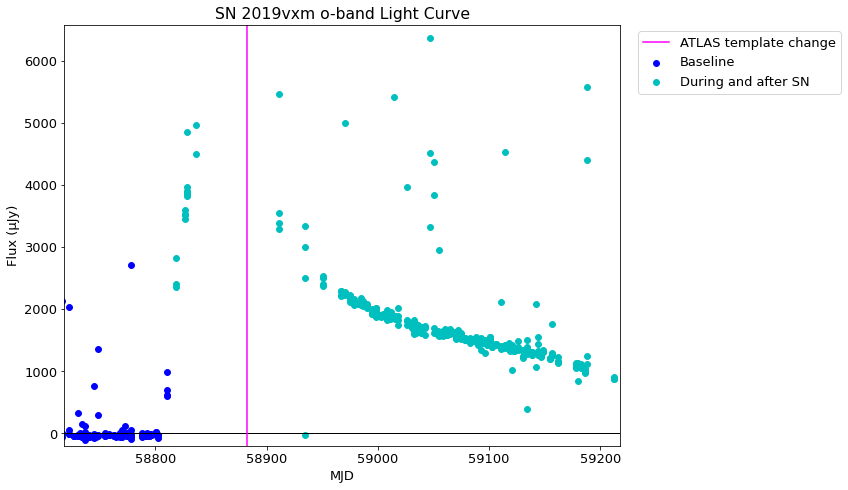

In [5]:
# plot the light curve

def get_xth_percentile_flux(percentile, indices):
    if len(indices)==0: 
        return None
    else:
        return np.percentile(lc_info['lc'].t.loc[indices, 'uJy'], percentile)

def plot_lc(xlim_lower=None, xlim_upper=None, ylim_lower=None, ylim_upper=None):
    fig, ax = plt.subplots(nrows=1, ncols=1)
    ax.axhline(linewidth=1,color='k')
    ax.set_ylabel('Flux (µJy)')
    ax.set_xlabel('MJD')
    ax.set_title('SN %s %s-band Light Curve' % (lc_info['tnsname'], lc_info['filter']))
    ax.axvline(x=tchange1,color='magenta', label='ATLAS template change')
    ax.axvline(x=tchange2,color='magenta')

    # set x and y limits
    if xlim_lower is None: xlim_lower = lc_info['discdate']-100
    if xlim_upper is None: xlim_upper = lc_info['discdate']+400
    ax.set_xlim(xlim_lower, xlim_upper)
    if ylim_lower is None: ylim_lower = -200
    if ylim_upper is None: ylim_upper = scale*get_xth_percentile_flux(95, lc_info['afterdiscdate_i'])
    ax.set_ylim(ylim_lower,ylim_upper)

    ax.scatter(lc_info['lc'].t.loc[lc_info['baseline_i'],'MJD'], lc_info['lc'].t.loc[lc_info['baseline_i'],'uJy'], 
               s=35,color='b',marker='o',label='Baseline')

    ax.scatter(lc_info['lc'].t.loc[lc_info['afterdiscdate_i'],'MJD'], lc_info['lc'].t.loc[lc_info['afterdiscdate_i'],'uJy'],
               s=35,color='c',marker='o',label='During and after SN')
    
    plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left')

    fig.tight_layout()

plot_lc(xlim_lower=xlim_lower, xlim_upper=xlim_upper, ylim_lower=ylim_lower, ylim_upper=ylim_upper)

### 3: Plot the flux/dflux and chi-square distributions

[INSERT DESCRIPTION HERE]

In [6]:
# Optionally, manually enter the histograms' x limits here:
fdf_xlim_lower = None
fdf_xlim_upper = None
x2_xlim_lower = None
x2_xlim_upper = None

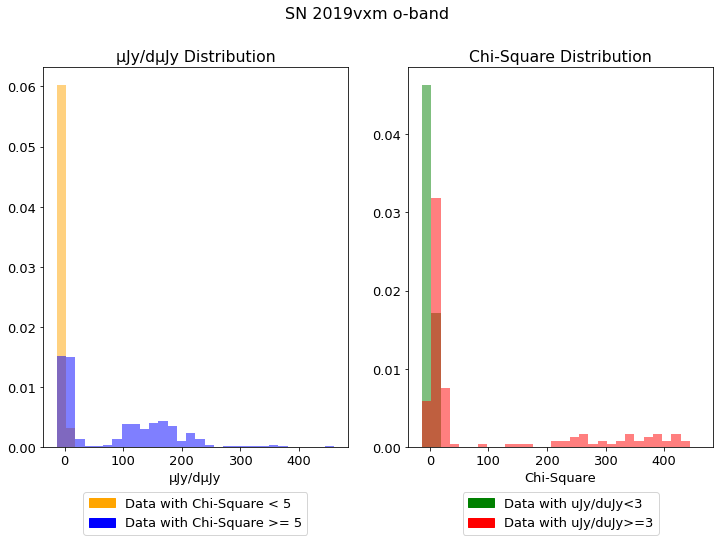

In [8]:
def plot_hists(fdf_xlim_lower=None, fdf_xlim_upper=None, x2_xlim_lower=None, x2_xlim_upper=None):
    good_stn_b = AandB(lc_info['baseline_i'],np.where(lc_info['lc'].t['uJy/duJy'] < 3.0)[0])
    bad_stn_b = AandB(lc_info['baseline_i'],np.where(lc_info['lc'].t['uJy/duJy'] >= 3.0)[0])
    good_x2_b = AandB(lc_info['baseline_i'],np.where(lc_info['lc'].t['chi/N'] < 5.0)[0])
    bad_x2_b = AandB(lc_info['baseline_i'],np.where(lc_info['lc'].t['chi/N'] >= 5.0)[0])

    fig, axes = plt.subplots(nrows=1, ncols=2)
    stn, x2 = axes.flatten()
    plt.suptitle('SN %s %s-band' % (lc_info['tnsname'], lc_info['filter']), fontsize=16, y=1)

    stn.set_title('µJy/dµJy Distribution')
    stn.set_xlabel('µJy/dµJy')
    orange = mpatches.Patch(color='orange', label='Data with Chi-Square < 5')
    blue = mpatches.Patch(color='blue', label='Data with Chi-Square >= 5')
    stn.legend(handles=[orange, blue], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
    if len(lc_info['baseline_i'])>0: 
        if fdf_xlim_lower is None: 
            fdf_xlim_lower = min(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy/duJy'])
        if fdf_xlim_upper is None: 
            fdf_xlim_upper = max(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy/duJy'])
        stn.hist(lc_info['lc'].t.loc[good_x2_b, 'uJy/duJy'], bins=30, color='orange', alpha=0.5, range=(fdf_xlim_lower,fdf_xlim_upper), density=True)
        stn.hist(lc_info['lc'].t.loc[bad_x2_b, 'uJy/duJy'], bins=30, color='blue', alpha=0.5, range=(fdf_xlim_lower,fdf_xlim_upper), density=True)
    else:
        stn.hist(lc_info['lc'].t.loc[good_x2_b, 'uJy/duJy'], bins=30, color='orange', alpha=0.5, density=True)
        stn.hist(lc_info['lc'].t.loc[bad_x2_b, 'uJy/duJy'], bins=30, color='blue', alpha=0.5, density=True)

    x2.set_title('Chi-Square Distribution')
    x2.set_xlabel('Chi-Square')
    red = mpatches.Patch(color='green', label='Data with uJy/duJy<3')
    green = mpatches.Patch(color='red', label='Data with uJy/duJy>=3')
    x2.legend(handles=[red, green], loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1)
    if len(lc_info['baseline_i'])>0:
        if x2_xlim_lower is None: x2_xlim_lower = min(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy/duJy'])
        if x2_xlim_upper is None: x2_xlim_upper = max(lc_info['lc'].t.loc[lc_info['baseline_i'], 'uJy/duJy'])
        x2.hist(lc_info['lc'].t.loc[good_stn_b, 'chi/N'], bins=30, color='green', alpha=0.5, range=(x2_xlim_lower,x2_xlim_upper), density=True)
        x2.hist(lc_info['lc'].t.loc[bad_stn_b, 'chi/N'], bins=30, color='red', alpha=0.5, range=(x2_xlim_lower,x2_xlim_upper), density=True)
    else:
        x2.hist(lc_info['lc'].t.loc[good_stn_b, 'chi/N'], bins=30, color='green', alpha=0.5, density=True)
        x2.hist(lc_info['lc'].t.loc[bad_stn_b, 'chi/N'], bins=30, color='red', alpha=0.5, density=True)

plot_hists(fdf_xlim_lower=fdf_xlim_lower, fdf_xlim_upper=fdf_xlim_upper, x2_xlim_lower=x2_xlim_lower, x2_xlim_upper=x2_xlim_upper)